<img width="400" src="https://nomeroff.net.ua/images/logo/nomeroff_net.svg" alt="Nomeroff Net. Automatic numberplate recognition system" align="left"/>

## The example demonstrates license plate number detection.

Before runing this demo, please download models from [https://nomeroff.net.ua/models/](https://nomeroff.net.ua/models/) to **./models/** directory. 

In [2]:
#Specify device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" 
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""  # For CPU inference

In [3]:
# Import all necessary libraries.
import numpy as np
import sys
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import copy

# NomeroffNet path
NOMEROFF_NET_DIR = os.path.abspath('../')
sys.path.append(NOMEROFF_NET_DIR)

In [4]:
from NomeroffNet.YoloV5Detector import Detector

detector = Detector()
detector.load()

2021-04-22 10:55:47,691 [329876] WARNING  py.warnings:109: [JupyterRequire] /usr/local/lib64/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0



Fusing layers... 


In [5]:
from BBoxNpMultiline import MultilineConverter
from NomeroffNet.BBoxNpPoints import (NpPointsCraft, 
                                      getCvZoneRGB, 
                                      remove_coordinates_offset,
                                      convertCvZonesRGBtoBGR, 
                                      reshapePoints)

npPointsCraft = NpPointsCraft()
npPointsCraft.load()

Loading weights of refiner from checkpoint (/mnt/data/var/www/nomeroff-net/NomeroffNet/Base/mcm/./models/NpPointsCraft/refiner/craft_refiner_CTW1500_2020-02-16.pth )


In [6]:
from NomeroffNet.OptionsDetector import OptionsDetector
from NomeroffNet.TextDetector import TextDetector

optionsDetector = OptionsDetector()
optionsDetector.load("latest")

# Initialize text detector.
textDetector = TextDetector({
    "eu_ua_2004_2015": {
        "for_regions": ["eu_ua_2015", "eu_ua_2004"],
        "model_path": "latest"
    },
    "eu_ua_1995": {
        "for_regions": ["eu_ua_1995"],
        "model_path": "latest"
    },
    "eu": {
        "for_regions": ["eu"],
        "model_path": "latest"
    },
    "ru": {
        "for_regions": ["ru", "eu-ua-fake-lnr", "eu-ua-fake-dnr"],
        "model_path": "latest" 
    },
    "kz": {
        "for_regions": ["kz"],
        "model_path": "latest"
    },
    "ge": {
        "for_regions": ["ge"],
        "model_path": "latest"
    },
    "su": {
        "for_regions": ["su"],
        "model_path": "latest"
    }
})

In [7]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

eu_ua_2015 [[192.0, 451.57333335573014], [192.00000213623048, 409.759996626377], [277.0, 409.75999282658097], [277.0, 451.5733278287541]]


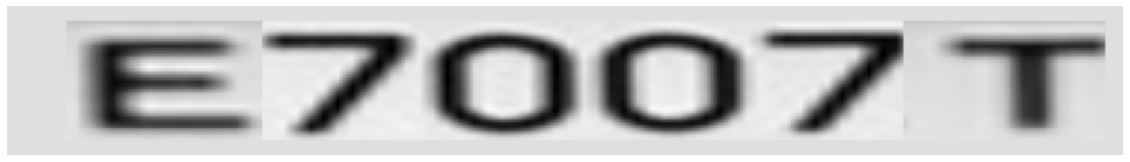

['E7000AT']


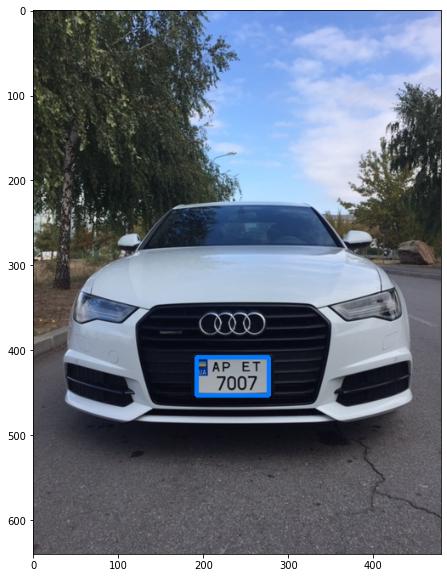

kz [[283.45505148711675, 696.8482834134302], [283.4550514871168, 609.8603350460913], [407.46652503807036, 625.8046687883896], [407.466534635082, 712.7926156781975]]


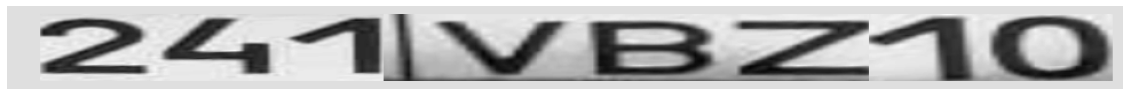

['41VBZ10']


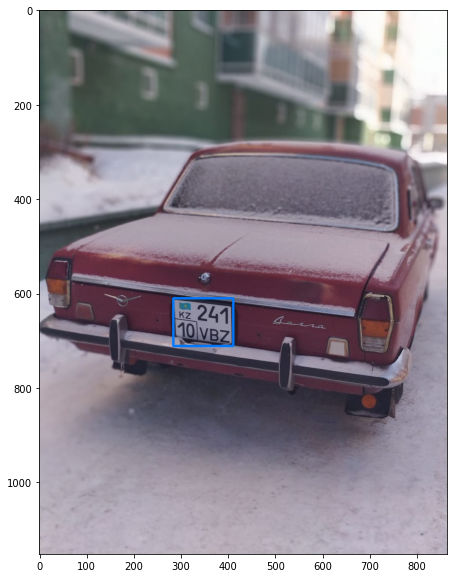

In [12]:
rootDir = 'multiple_number_plate_images/*'

imgs = [mpimg.imread(img_path) for img_path in glob.glob(rootDir)]

for img in imgs:
    targetBoxes = detector.detect_bbox(copy.deepcopy(img))
    targetBoxes = targetBoxes

    all_points, all_properties = npPointsCraft.detect(img, targetBoxes, return_properties=True)
    all_points = [ps for ps in all_points if len(ps)]

     # cut zones
    toShowZones = [getCvZoneRGB(img, reshapePoints(rect, 1)) for rect in all_points]
    zones = convertCvZonesRGBtoBGR(toShowZones)

    # find standart
    region_ids, countLines = optionsDetector.predict(zones)
    region_names = optionsDetector.getRegionLabels(region_ids)
    
    zones = npPointsCraft.multiline_to_one_line(zones, all_points, all_properties, region_names)
    for zone, points, region_name in zip(convertCvZonesRGBtoBGR(zones), all_points, region_names):
        print(region_name, points)
        plt.axis("off")
        plt.imshow(zone)
        plt.show()

    # find text with postprocessing by standart  
    textArr = textDetector.predict(zones, region_names, countLines)
    print(textArr)
    
    # draw rect and 4 points
    for targetBox, points in zip(targetBoxes, all_points):
        cv2.rectangle(img, 
                      (int(targetBox[0]), int(targetBox[1])), 
                      (int(targetBox[2]), int(targetBox[3])), 
                      (0,120,255), 
                      3)
    plt.imshow(img)
    plt.show()